In [122]:
#import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
random = 42

# Part 1- Data Preprocessing

In [108]:
test_data_path = '../data/test.csv'
train_data_path = '../data/train.csv'

In [109]:
test_data = pd.read_csv(test_data_path)
train_data = pd.read_csv(train_data_path, nrows=500000) # loading first 5 million rows (out of over 55 million)

In [110]:
# filter out NA vals
test_data = test_data.dropna()
train_data = train_data.dropna()

# filter out negative fares, 0 passenger fares, and fares outside of nyc
train_data = train_data.loc[
    (train_data['fare_amount'] > 2) &
    (train_data['passenger_count'] > 0) &
    (train_data['pickup_longitude'].between(-74.27, -73.68)) &
    (train_data['pickup_latitude'].between(40.49, 40.92)) &
    (train_data['dropoff_longitude'].between(-74.27, -73.68)) &
    (train_data['dropoff_latitude'].between(40.49, 40.92))
]
test_data = test_data.loc[
    (test_data['passenger_count'] > 0) &
    (test_data['pickup_longitude'].between(-74.27, -73.68)) &
    (test_data['pickup_latitude'].between(40.49, 40.92)) &
    (test_data['dropoff_longitude'].between(-74.27, -73.68)) &
    (test_data['dropoff_latitude'].between(40.49, 40.92))
]

In [111]:
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'])
train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'])

In [112]:
# extract day, hour, weekday, and month from datetime
frames = [train_data, test_data]
for df in frames:
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day'] = df['pickup_datetime'].dt.day
    df['weekday'] = df['pickup_datetime'].dt.weekday  # 0=Monday, 6=Sunday
    df['month'] = df['pickup_datetime'].dt.month

train_data

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,weekday,month
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,0,6
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,3,8
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12+00:00,-73.978775,40.766724,-73.966072,40.758537,1,18,7,3,5
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34+00:00,-74.002932,40.718408,-74.009442,40.710952,1,12,13,0,9
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20+00:00,-73.983885,40.725611,-73.896482,40.700980,1,0,25,0,8
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32+00:00,-73.974617,40.756512,-73.970184,40.764801,6,12,12,0,1


In [113]:
# calculate haversine distance
import math
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth's radius in kilometers

    # convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # differences in coordinates
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1

    # Haversine formula
    a = np.sin(delta_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

In [114]:
for df in frames:
    df['h_dist (km)'] = haversine_vectorized(
        df['pickup_latitude'].values, df['pickup_longitude'].values,
        df['dropoff_latitude'].values, df['dropoff_longitude'].values
    )

In [115]:
# group into 5 clusters (for major boroughs: Bronx, Brooklyn, Manhattan, Queens, and Staten Island)
from sklearn.cluster import KMeans

In [116]:
# apply K-means clustering
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pickup_coords = scaler.fit_transform(train_data[['pickup_latitude', 'pickup_longitude']])
dropoff_coords = scaler.fit_transform(train_data[['dropoff_latitude', 'dropoff_longitude']])

kmeans_pickup = KMeans(n_clusters=5, random_state = random, init='k-means++')
train_data['pickup_cluster'] = kmeans_pickup.fit_predict(pickup_coords)

kmeans_dropoff = KMeans(n_clusters=5, random_state=random, init='k-means++')
train_data['dropoff_cluster'] = kmeans_dropoff.fit_predict(dropoff_coords)

In [141]:
import folium
from scipy.spatial import ConvexHull

# Initialize a map centered around NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12, 
                     tiles='CartoDB positron', 
                     control_scale=True)

# GeoJSON for specific areas (simplified example)
boroughs_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {"borough": "Central Park"},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [-73.974, 40.764], [-73.958, 40.764], [-73.958, 40.785], [-73.974, 40.785], [-73.974, 40.764]
                    ]
                ]
            }
        },
        {
            "type": "Feature",
            "properties": {"borough": "Midtown"},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [-73.995, 40.745], [-73.975, 40.745], [-73.975, 40.765], [-73.995, 40.765], [-73.995, 40.745]
                    ]
                ]
            }
        },
        {
            "type": "Feature",
            "properties": {"borough": "SoHo"},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [-74.005, 40.725], [-73.990, 40.725], [-73.990, 40.740], [-74.005, 40.740], [-74.005, 40.725]
                    ]
                ]
            }
        },
        {
            "type": "Feature",
            "properties": {"borough": "Brooklyn"},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [-74.02, 40.57], [-73.85, 40.57], [-73.85, 40.75], [-74.02, 40.75], [-74.02, 40.57]
                    ]
                ]
            }
        },
        #JFK Airport Region
        {
            "type": "Feature",
            "properties": {"borough": "JFK Airport"},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [-73.838, 40.64], [-73.783, 40.64], [-73.783, 40.67], [-73.838, 40.67], [-73.838, 40.64]
                    ]
                ]
            }
        },
        # LaGuardia Airport Region
        {
            "type": "Feature",
            "properties": {"borough": "LaGuardia Airport"},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [-73.880, 40.76], [-73.830, 40.76], [-73.830, 40.78], [-73.880, 40.78], [-73.880, 40.76]
                    ]
                ]
            }
        }
    ]
}

# Initialize the map centered around NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12, tiles='CartoDB positron')

# Add GeoJSON data for specific areas (boroughs) to map with coloring and labels
for feature in boroughs_geojson['features']:
    # Get the name of the borough/area
    borough_name = feature['properties']['borough']
    
    # Get the coordinates for the label position (centroid of the polygon)
    coordinates = feature['geometry']['coordinates'][0]
    label_lat = sum([coord[1] for coord in coordinates]) / len(coordinates)
    label_lon = sum([coord[0] for coord in coordinates]) / len(coordinates)
    
    # Add the polygon (filled area)
    folium.GeoJson(
        feature,
        name=borough_name,
        style_function=lambda feature: {
            'fillColor': 'blue' if feature['properties']['borough'] == 'Central Park' else
                         'green' if feature['properties']['borough'] == 'Midtown' else
                         'yellow' if feature['properties']['borough'] == 'SoHo' else
                         'purple' if feature['properties']['borough'] == 'Brooklyn' else
                         'lightgreen' if feature['properties']['borough'] == 'JFK Airport' else
                         'darkgreen' if feature['properties']['borough'] == 'LaGuardia Airport' else 'gray',
            'color': 'black',
            'weight': 2,
            'fillOpacity': 0.3
        }
    ).add_to(nyc_map)

    # Add a label for the borough
    folium.Marker(
        location=[label_lat, label_lon],
        popup=borough_name,
        icon=folium.Icon(color='black', icon='info-sign')
    ).add_to(nyc_map)

# Create a marker cluster to group the points
marker_cluster = folium.plugins.MarkerCluster().add_to(nyc_map)

# Assuming 'train_data' is your DataFrame and it has columns for the cluster labels

# Calculate centroids for each cluster for both pickup and dropoff
pickup_centroids = train_data.groupby('pickup_cluster')[['pickup_latitude', 'pickup_longitude']].mean()
dropoff_centroids = train_data.groupby('dropoff_cluster')[['dropoff_latitude', 'dropoff_longitude']].mean()

# Plot the pickup cluster centroids on the map (blue markers)
for idx, centroid in pickup_centroids.iterrows():
    folium.Marker(
        location=[centroid['pickup_latitude'], centroid['pickup_longitude']],
        popup=f'Pickup Cluster: {idx}',
        icon=folium.Icon(color='blue')
    ).add_to(marker_cluster)

# Plot the dropoff cluster centroids on the map (red markers)
for idx, centroid in dropoff_centroids.iterrows():
    folium.Marker(
        location=[centroid['dropoff_latitude'], centroid['dropoff_longitude']],
        popup=f'Dropoff Cluster: {idx}',
        icon=folium.Icon(color='red')
    ).add_to(marker_cluster)

nyc_map.fit_bounds([[40.4774, -74.2591], [40.9176, -73.7004]])

# Show the map (if using Jupyter Notebook, this will display inline)
nyc_map


In [119]:
print(train_data[['pickup_latitude', 'pickup_longitude']].min())
print(train_data[['pickup_latitude', 'pickup_longitude']].max())
print(train_data[['dropoff_latitude', 'dropoff_longitude']].min())
print(train_data[['dropoff_latitude', 'dropoff_longitude']].max())

pickup_latitude     40.492546
pickup_longitude   -74.269746
dtype: float64
pickup_latitude     40.918290
pickup_longitude   -73.683333
dtype: float64
dropoff_latitude     40.490235
dropoff_longitude   -74.269480
dtype: float64
dropoff_latitude     40.919305
dropoff_longitude   -73.680115
dtype: float64


In [118]:
(train_data['dropoff_cluster'] == 4).sum()

115784

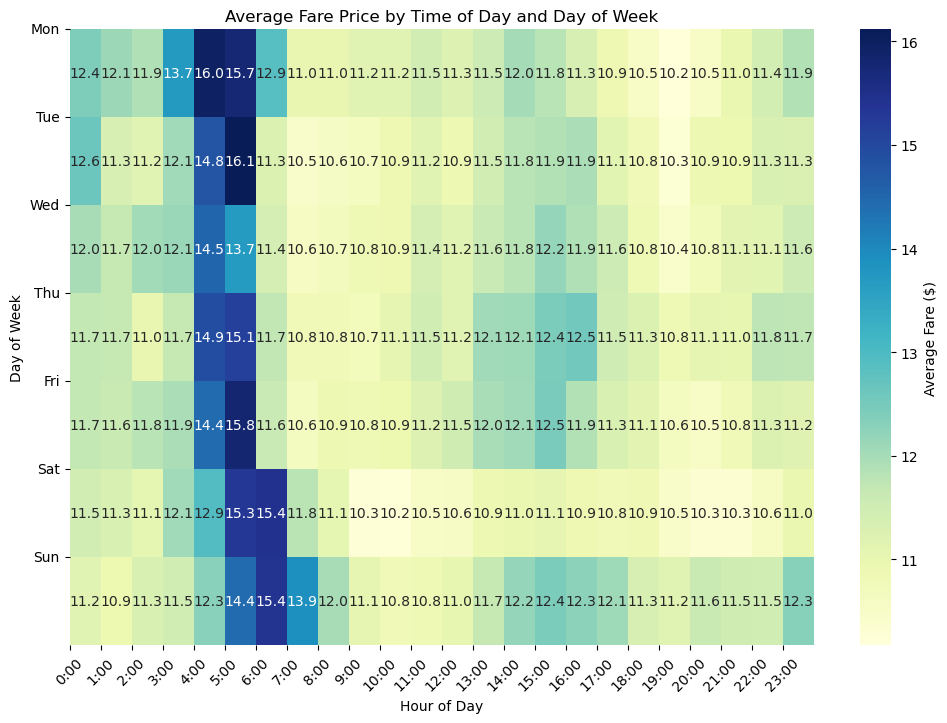

In [124]:
# Create heatmap to determine peak fare hours/days

# Compute the average fare amount based on time of day and day of the week
pivot_data = train_data.pivot_table(
    values='fare_amount',
    index='weekday',  # Rows represent days of the week (0-6)
    columns='hour',  # Columns represent hours of the day (0-23)
    aggfunc='mean',  # We want the average fare for each combination
    fill_value=0  # Fill missing values with 0 (or use another placeholder if needed)
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt='.1f', cbar_kws={'label': 'Average Fare ($)'})
plt.title('Average Fare Price by Time of Day and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.xticks(ticks=range(0, 24), labels=[f'{i}:00' for i in range(24)], rotation=45)
plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()
